# Point Cloud Classification

> Point cloud is an important type of geometric data structure that comprises of data points represented in 3D space. Due to its irregular format, most researchers transform such data to regular 3D voxel grids or collections of images. This, however, renders data unnecessarily voluminous and causes issues.

> ***PointNet***, provides a unified architecture for applications ranging from object classification, part segmentation, to scene semantic parsing. Being simple, PointNet is highly efficient and effective, that directly consumes point clouds, which well respects the permutation invariance of points in the input. Empirically, it shows strong performance on par or even better than state of the art.

    This notebook explains the classification of point clouds of different objects using PointNet.

In [1]:
import os
import numpy as np
import itertools
import math, random
from tqdm.notebook import tqdm
import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import glob
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchview import draw_graph # Ref and credits: https://github.com/mert-kurttutan/torchview for visualizing model graph.
from torchsummary import summary

### 1. Dataset pre-processing

In [2]:
# Dataset ref: https://www.kaggle.com/datasets/balraj98/modelnet10-princeton-3d-object-dataset
random.seed = 34
folders = 'modelnet-10\ModelNet10' # 3D pointclouds for 10 categories
os.listdir(folders)

['bathtub',
 'bed',
 'chair',
 'desk',
 'dresser',
 'monitor',
 'night_stand',
 'sofa',
 'table',
 'toilet']

In [3]:
out_class = {folder : i for i, folder in enumerate(os.listdir(folders))}
out_class

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [4]:
"""Function to read the point cloud data"""

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces
"""----------------------------------------------------------------------------------------------------------------------------------"""

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout = go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig

"""Function to visualize the cloud data"""

def pcshow(xs,ys,zs):
    data = [go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()


In [5]:
with open(f"{folders}/dresser/train/dresser_0020.off", 'r') as f:
    verts, faces = read_off(f)
    
i, j, k = np.array(faces).T
x, y, z = np.array(verts).T
len(x)

10557

In [6]:
np.array(verts).T.shape

(3, 10557)

In [7]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='brown', opacity=0.5, i=i,j=j,k=k)]).show()

In [8]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

In [9]:
# Display the key points
pcshow(x, y, z)

In [10]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
pointcloud = PointSampler(3000)((verts, faces))
pcshow(*pointcloud.T)

In [11]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [12]:
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

In [13]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [14]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
pcshow(*noisy_rot_pointcloud.T)

In [15]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [16]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [17]:
"""Class to create torch dataset for train and validation"""

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid = False, folder = "train", transform = default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = os.path.join(root_dir, category, folder)
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = os.path.join(new_dir, file)
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [18]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [19]:
val_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    ToTensor()
                    ])

In [20]:
folders

'modelnet-10\\ModelNet10'

In [21]:
train_ds = PointCloudData(folders, transform = train_transforms)
valid_ds = PointCloudData(folders, valid = True, folder = 'test', transform = val_transforms)

In [22]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [23]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [24]:
Train_Dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)
Val_Dl = DataLoader(dataset = valid_ds, batch_size = 32)

### 2. Pointnet Architecture
PointNet has three key modules
* Max-pooling layer - Acts as a symmetric function to aggregate information from all the points, a local and global information combination structure.
* Two joint alignment/transformation networks - Align both input points and point features.

#### 2.1. T-Net

The semantic labelling of a point cloud has to be invariant if the point cloud undergoes certain geometric transformations, such as rigid transformations. Thus learnt representation from point set is to be invariant to these transformation.

> This mini-network plays the role of predicting affine transformation matrix and directly apply this transformation to the coordinates of input points. [1]

In [25]:
"""Class for Joint Alignment/Transformation Network"""
class Tnet(nn.Module):

    """
    The network is composed of shared MLP (in this case Convolution layer is used as shared MLP 
    due to the weight sharing feature across points), max pooling and fully
    connected layers. All layers, except the last one, include ReLU activation and
    batch normalization. [1]
    
    """
    def __init__(self, dim: int):
        super().__init__()
        """
        Args:
        dim -> Output dimension of transformation matrix.

        """
        self.dim = dim
        self.conv1 = nn.Conv1d(dim, 64, kernel_size = 1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size = 1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size = 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x) -> torch.Tensor:

        bs = x.shape[0]
        # Shared MLP
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))

        # Maxpool
        out = nn.MaxPool1d(out.size(-1))(out) 
        out = out.view(bs, -1)
        # out = nn.Flatten(1)(out)

        # Fully Connected layers
        out = F.relu(self.bn4(self.fc1(out)))
        out = F.relu(self.bn5(self.fc2(out)))
        out = self.fc3(out)

        # Identity matrix
        idm = torch.eye(self.dim, requires_grad = True).repeat(bs, 1, 1)
        if out.is_cuda:
            idm = idm.cuda()
        
        out = out.view(-1, self.dim, self.dim) + idm 

        return out

#### 2.2. PointNet Backbone

In [26]:
"""Class for PointNet backbone"""
class Transform(nn.Module):

    """
    This backbone serves as a common block for both classification and part segmentation for pointNet.
    It comprises of
        - Input Transformation network (T-Net, Matrix multiply)
        - Shared MLP (3, 64)
        - Feature Transformation network (T-Net, Matrix multiply)
        - Share MLP (64, 128, 1024)
        - Max pooling

    """

    def __init__(self, global_feats: int = 1024):
        super().__init__()
        """
        Args:
        global_feats -> Sampled points as global features.

        """
        self.global_feats = global_feats
        self.input_transform = Tnet(dim = 3)
        self.feature_transform = Tnet(dim = 64)

        # Shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size = 1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size = 1)

        # Shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size = 1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size = 1)
        self.conv5 = nn.Conv1d(128, self.global_feats, kernel_size = 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.global_feats)

    def forward(self, x):

        bs = x.shape[0]
        # input transform
        ip_tfm = self.input_transform(x)
        out = torch.bmm(torch.transpose(x, 1, 2), ip_tfm).transpose(1, 2)

        # Shared MLP 1
        out = F.relu(self.bn1(self.conv1(out)))
        out = F.relu(self.bn2(self.conv2(out)))

        # feature transform
        fea_tfm = self.feature_transform(out)
        out = torch.bmm(torch.transpose(out, 1, 2), fea_tfm).transpose(1, 2)

        # Shared MLP 2
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = F.relu(self.bn5(self.conv5(out)))

        out, critical_idx = nn.MaxPool1d(out.size(-1), return_indices = True)(out) 
        # print(out.shape)
        # print(critical_idx.shape)
        out = out.view(bs, -1)
        critical_idx = critical_idx.view(bs, -1)
        # out = nn.Flatten(1)(out)
        # print(out.shape)

        return out, ip_tfm, fea_tfm, critical_idx

#### 2.3. PointNet Classification network

In [27]:
"""Class for Classification head for pointnet"""
class PointNetClassHead(nn.Module):
    """
    The processed global features from backbone is then send to classification to classify the 3D point 
    clouds into different categories.

    """

    def __init__(self, k: int, global_feats: int = 1024):
        super().__init__()
        """
        Args:
        k -> Number of classes.
        global_feats -> Sampled points as global features.

        """
        self.backbone = Transform(global_feats)

        self.linear1 = nn.Linear(global_feats, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p = 0.3)
        self.logsoftmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):

        out, ip_tfm, fea_tfm, critical_idx = self.backbone(x)

        out = F.relu(self.bn1(self.linear1(out)))
        out = F.relu(self.bn2(self.linear2(out)))
        out = self.dropout(out)
        out = self.linear3(out)
        out = self.logsoftmax(out)

        return out, ip_tfm, fea_tfm, critical_idx



In [28]:
test_data = torch.rand(5, 3, 2500)
pointnet = PointNetClassHead(k = 10)

In [29]:
Num_of_parameters = sum(p.numel() for p in pointnet.parameters())
print("Model Parameters : {:.3f} M".format(Num_of_parameters / 1e6))

Model Parameters : 3.472 M


In [30]:
summary(pointnet, [(test_data)], device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Transform: 1-1                         [-1, 1024]                --
|    └─Tnet: 2-1                         [-1, 3, 3]                --
|    |    └─Conv1d: 3-1                  [-1, 64, 2500]            256
|    |    └─BatchNorm1d: 3-2             [-1, 64, 2500]            128
|    |    └─Conv1d: 3-3                  [-1, 128, 2500]           8,320
|    |    └─BatchNorm1d: 3-4             [-1, 128, 2500]           256
|    |    └─Conv1d: 3-5                  [-1, 1024, 2500]          132,096
|    |    └─BatchNorm1d: 3-6             [-1, 1024, 2500]          2,048
|    |    └─Linear: 3-7                  [-1, 512]                 524,800
|    |    └─BatchNorm1d: 3-8             [-1, 512]                 1,024
|    |    └─Linear: 3-9                  [-1, 256]                 131,328
|    |    └─BatchNorm1d: 3-10            [-1, 256]                 512
|    |    └─Linear: 3-11                 [-1, 9]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Transform: 1-1                         [-1, 1024]                --
|    └─Tnet: 2-1                         [-1, 3, 3]                --
|    |    └─Conv1d: 3-1                  [-1, 64, 2500]            256
|    |    └─BatchNorm1d: 3-2             [-1, 64, 2500]            128
|    |    └─Conv1d: 3-3                  [-1, 128, 2500]           8,320
|    |    └─BatchNorm1d: 3-4             [-1, 128, 2500]           256
|    |    └─Conv1d: 3-5                  [-1, 1024, 2500]          132,096
|    |    └─BatchNorm1d: 3-6             [-1, 1024, 2500]          2,048
|    |    └─Linear: 3-7                  [-1, 512]                 524,800
|    |    └─BatchNorm1d: 3-8             [-1, 512]                 1,024
|    |    └─Linear: 3-9                  [-1, 256]                 131,328
|    |    └─BatchNorm1d: 3-10            [-1, 256]                 512
|    |    └─Linear: 3-11                 [-1, 9]         


(process:5928): Pango-WARNING **: 17:22:08.983: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


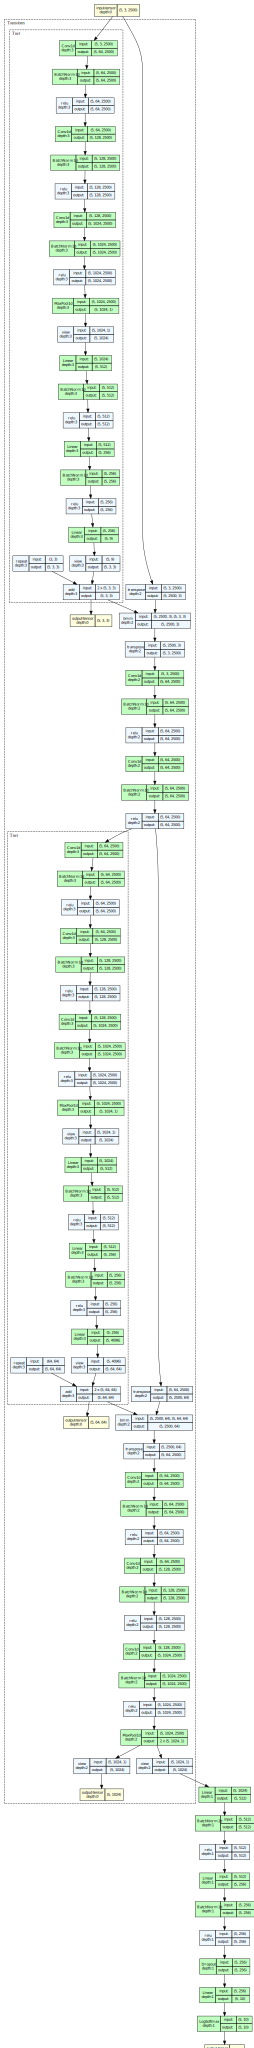

In [31]:
model_graph = draw_graph(pointnet, input_data = (test_data), device = 'cpu', expand_nested=True)
model_graph.visual_graph

In [32]:
out = pointnet(test_data)
out[0].shape

torch.Size([5, 10])

In [33]:
"""Function to calculate loss"""

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad = True).repeat(bs, 1, 1) # Input transform matrix
    id64x64 = torch.eye(64, requires_grad = True).repeat(bs, 1, 1) # Feature transform matrix
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs) # (Categorical loss + Regularization)

In [34]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(torch.cuda.get_device_properties(i))
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move Tensors to chosen device"""
    if isinstance(data, (list,tuple,dict)):
        return [to_device(data[x], device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
print(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)
cuda


In [36]:
Train_Dl = DeviceDataLoader(Train_Dl, device)
Val_Dl = DeviceDataLoader(Val_Dl, device)

In [37]:
pointnet.to(device)

PointNetClassHead(
  (backbone): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_

### 3. Training and Evaluation

In [37]:
lr = 6e-4
optimizer = torch.optim.Adam(pointnet.parameters(), lr = lr)

In [38]:
def Accuracy(pred_labels: torch.Tensor, true_labels: torch.Tensor) -> float:
    acc = sum(1 for y_pred, y in zip(pred_labels, true_labels) if y_pred == y) / len(true_labels)
    return acc

In [39]:
"""Function for Train and validation"""

def train(train_loader: DataLoader, val_loader: DataLoader = None, epochs: int = 4):
    Train_Loss = []
    Val_Loss = []
    Train_acc = []
    Val_acc = []
    
    for epoch in range(epochs): 
        pointnet.train()
        Train_Losses = []
        Val_Losses = []
        Train_true_labels = []
        Val_true_labels = []
        Train_pred_labels = []
        Val_pred_labels = []
        for input in tqdm(train_loader):
            inputs, labels = input[0].float(), input[1]
            optimizer.zero_grad()
            outputs, m3x3, m64x64, _ = pointnet(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            Train_true_labels.extend(labels)
            Train_pred_labels.extend(predicted)

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            Train_Losses.append(loss)
        
        train_loss = torch.stack(Train_Losses).mean().item()
        train_acc = Accuracy(torch.Tensor(Train_pred_labels), torch.Tensor(Train_true_labels))
        Train_acc.append(train_acc)
        Train_Loss.append(train_loss)
        pointnet.eval()

        # validation
        if val_loader:
            with torch.no_grad():
                for input in tqdm(val_loader):
                    inputs, labels = input[0].float(), input[1]
                    outputs, m3x3, m64x64, _ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    Val_true_labels.extend(labels)
                    Val_pred_labels.extend(predicted)

                    loss = pointnetloss(outputs, labels, m3x3, m64x64)
                    Val_Losses.append(loss)

        val_loss = torch.stack(Val_Losses).mean().item()
        val_acc = Accuracy(torch.Tensor(Val_pred_labels), torch.Tensor(Val_true_labels))
        Val_acc.append(val_acc)
        Val_Loss.append(val_loss)

        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}".format(
            epoch + 1, train_loss, val_loss, train_acc, val_acc))

    return Train_Loss, Val_Loss, Train_acc, Val_acc

In [40]:
epochs = 10
len(Train_Dl)

125

In [41]:
"""Kickstart the Training and validation"""
history = train(Train_Dl, val_loader = Val_Dl, epochs = epochs)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.3682, val_loss: 1.1861, train_accuracy: 0.5542, val_accuracy: 0.5782


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8227, val_loss: 0.9288, train_accuracy: 0.7279, val_accuracy: 0.6663


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6738, val_loss: 0.7293, train_accuracy: 0.7742, val_accuracy: 0.7665


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5869, val_loss: 1.0422, train_accuracy: 0.8036, val_accuracy: 0.7026


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5404, val_loss: 0.6966, train_accuracy: 0.8196, val_accuracy: 0.7610


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4879, val_loss: 0.5865, train_accuracy: 0.8386, val_accuracy: 0.8018


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4791, val_loss: 0.6430, train_accuracy: 0.8394, val_accuracy: 0.7621


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4408, val_loss: 0.5959, train_accuracy: 0.8574, val_accuracy: 0.7786


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4300, val_loss: 0.5825, train_accuracy: 0.8592, val_accuracy: 0.8018


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.3929, val_loss: 0.4752, train_accuracy: 0.8777, val_accuracy: 0.8293


In [42]:
"""Save the model checkpoint"""
torch.save(pointnet.state_dict(), 'pointnet_10_6e-4.pth')

In [43]:
train_loss, val_loss, train_acc, val_acc = history

Text(0.5, 1.0, 'Losses')

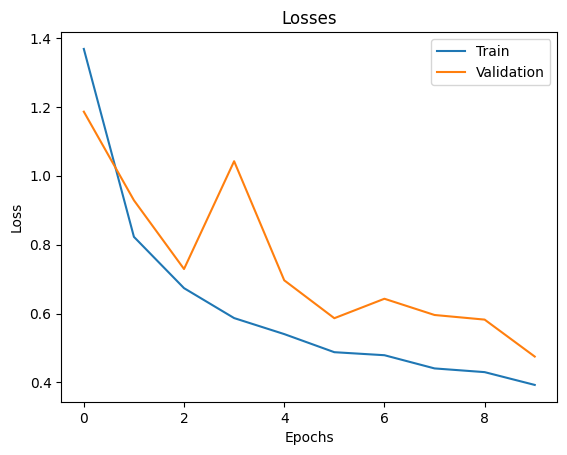

In [44]:
"""Combined Losses"""

plt.plot(train_loss, '-')
plt.plot(val_loss, '-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.title('Losses')

Text(0.5, 1.0, 'Accuracy')

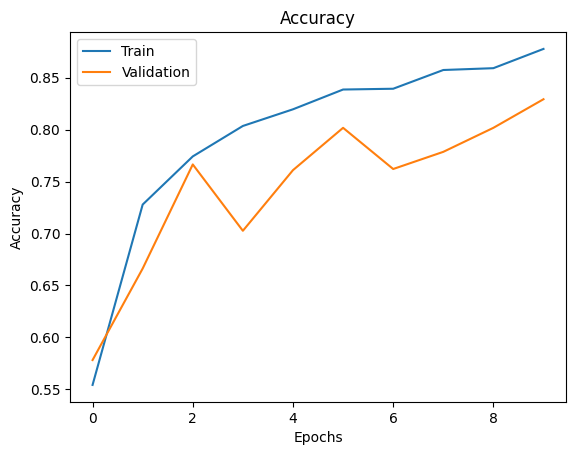

In [45]:
"""Combined Accuracy"""

plt.plot(train_acc, '-')
plt.plot(val_acc, '-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy')

In [46]:
# Evaluation on validation data
pointnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in tqdm(Val_Dl):
        inputs, labels = data[0].float(), data[1]
        outputs, _, _, _ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        preds = preds.detach().cpu()
        labels = labels.detach().cpu()
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

  0%|          | 0/29 [00:00<?, ?it/s]

In [47]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[ 45,   5,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  79,   1,   0,   0,   0,   0,  17,   1,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,  48,   1,   5,   0,  10,  20,   0],
       [  0,   0,   0,   1,  70,   4,   8,   1,   1,   1],
       [  0,   1,   2,   0,   6,  91,   0,   0,   0,   0],
       [  0,   0,   2,   1,  24,   1,  51,   0,   7,   0],
       [  0,   0,   1,   1,   0,   0,   1,  97,   0,   0],
       [  0,   0,   0,   8,   0,   0,   0,   1,  91,   0],
       [  0,   0,  12,   1,   1,   0,   0,   0,   0,  86]], dtype=int64)

In [48]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


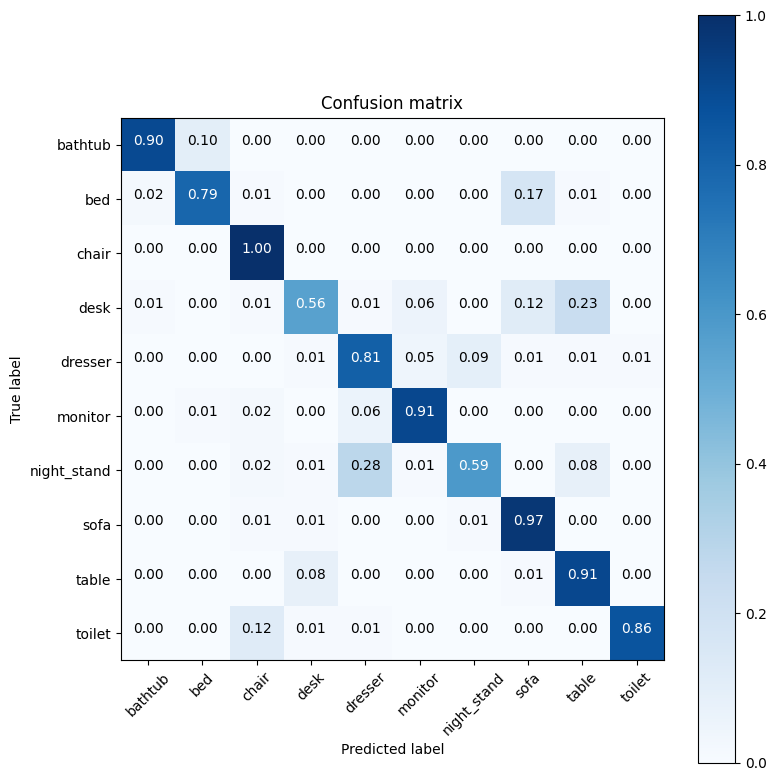

In [49]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(out_class.keys()), normalize=True)

Confusion matrix, without normalization


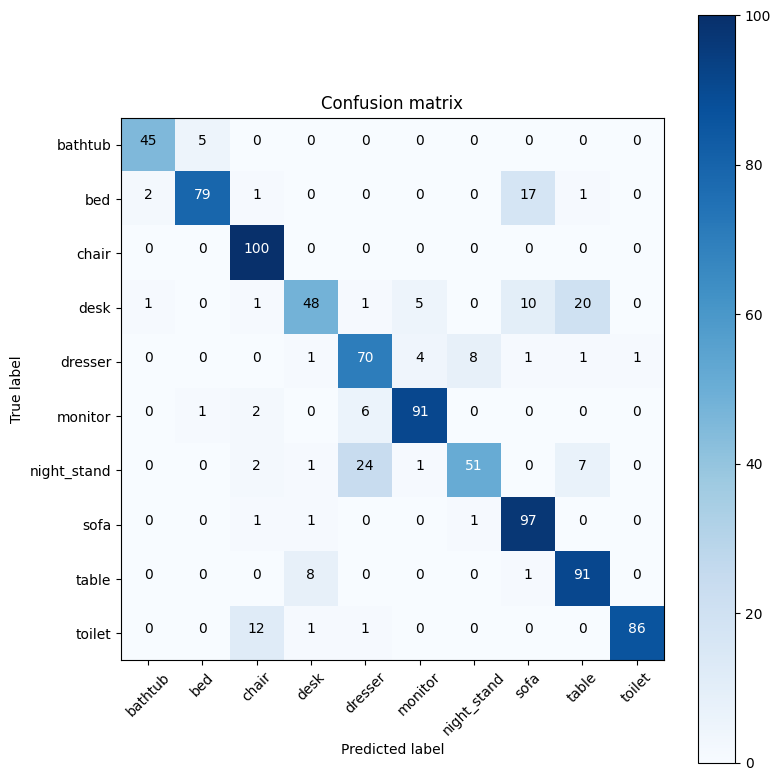

In [50]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(out_class.keys()), normalize=False)

### 4. Inference

In [38]:
pointnet.load_state_dict(torch.load('pointnet_10_6e-4.pth'))

<All keys matched successfully>

In [39]:
"""Function for inference of test data"""

def inference(category: str, device) -> None:

    files_list = glob.glob(f"{folders}/{category}/test/*.off")
    file = random.sample(files_list, 1)[0]
    with open(file, 'r') as f:
        verts, faces = read_off(f)
    i, j, k = np.array(faces).T
    x, y, z = np.array(verts).T
    visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='brown', opacity=0.5, i=i,j=j,k=k)]).show()

    pointcloud = PointSampler(3000)((verts, faces))
    norm_pointcloud = Normalize()(pointcloud)
    pcshow(*norm_pointcloud.T)

    pointnet.eval()
    with torch.no_grad():
            ip_pointcloud = val_transforms((verts, faces))
            ip_pointcloud = ip_pointcloud.T.unsqueeze(0).float().to(device)
            outputs, _, _, _ = pointnet(ip_pointcloud)
            _, pred = torch.max(outputs.data, 1)
            pred = pred.detach().cpu()

    pred = inv_classes[int(pred)]
    print("Ground truth: ", category)
    print("Predicted: ", pred)            

In [40]:
categories = os.listdir(folders)
categories

['bathtub',
 'bed',
 'chair',
 'desk',
 'dresser',
 'monitor',
 'night_stand',
 'sofa',
 'table',
 'toilet']

In [41]:
inference(categories[1], device)

Ground truth:  bed
Predicted:  bed


In [42]:
inference(categories[6], device)

Ground truth:  night_stand
Predicted:  night_stand


In [43]:
inference(categories[3], device)

Ground truth:  desk
Predicted:  desk


In [44]:
inference(categories[8], device)

Ground truth:  table
Predicted:  table


### 5. References

1. [PointNet paper](https://arxiv.org/pdf/1612.00593).
2. [Kaggle](https://www.kaggle.com/code/balraj98/pointnet-for-3d-object-classification-pytorch).
3. [Medium](https://medium.com/@itberrios6/introduction-to-point-net-d23f43aa87d2).